#Libraries


In [ ]:
#Data processing
import pandas as pd
import numpy as np
import nltk
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing   import LabelEncoder

#Model
import gensim
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from tensorflow.keras.models import load_model

#Evaluate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.callbacks import EarlyStopping


In [ ]:
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


#Load Data

In [ ]:
!gdown 1DB4yLBn6zfZfZva0sqVGfgt58AXL9jKN

Downloading...
From: https://drive.google.com/uc?id=1DB4yLBn6zfZfZva0sqVGfgt58AXL9jKN
To: /content/processed_youtube_data.csv
100% 41.9M/41.9M [00:00<00:00, 71.3MB/s]


In [ ]:
df =  pd.read_csv('/content/processed_youtube_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119366 entries, 0 to 119365
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Title_Description  117692 non-null  object
 1   View Count         119366 non-null  int64 
 2   Like Count         119366 non-null  int64 
 3   Topic              119366 non-null  object
 4   tokens             119366 non-null  object
 5   clean_title        117521 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.5+ MB


In [ ]:
df.head()

,Title_Description,View Count,Like Count,Topic,tokens,clean_title
0,Best Funny Animals Funniest Dogs and Cats Funn...,93719,210,Animals,"['best', 'funny', 'animal', 'funniest', 'dog',...",best funny animal funniest dog cat funniest an...
1,Animals Provided to YouTube by Roadrunner Reco...,26738388,240292,Animals,"['animal', 'provided', 'youtube', 'roadrunner'...",animal provided youtube roadrunner record anim...
2,Turf Angriest Animals Animal Fight Night Fins ...,41712,1047,Animals,"['turf', 'angriest', 'animal', 'animal', 'figh...",turf angriest animal animal fight night fin th...
3,Ocean Sea Animals for Beautiful Coral Reef Fis...,1081,396,Animals,"['ocean', 'sea', 'animal', 'beautiful', 'coral...",ocean sea animal beautiful coral reef fish aqu...
4,Wildlife The Fascinating World of Wild Animals...,1191645,5874,Animals,"['wildlife', 'fascinating', 'world', 'wild', '...",wildlife fascinating world wild animal full se...


In [ ]:
print(df.isna().sum())

Title_Description    1674
View Count              0
Like Count              0
Topic                   0
tokens                  0
clean_title          1845
dtype: int64


In [ ]:
print(f'Duplicates: {df.duplicated().sum()}')
print(f'Missing: \n{df.isna().sum()}')
# df = df.drop_duplicates()
# df = df.dropna()

Duplicates: 118
Missing: 
Title_Description    1674
View Count              0
Like Count              0
Topic                   0
tokens                  0
clean_title          1845
dtype: int64


In [ ]:
df.Topic.value_counts()

News & Politics          14306
Travel & Events          11371
Education                10611
NonProfit & Activism     10414
Science & Technology      9282
Film & Animation          9255
History & Documentary     9211
Food                      9100
Gaming                    9067
Animals                   9015
Sports                    8947
Music                     8787
Name: Topic, dtype: int64

In [ ]:
data = df[['clean_title', 'tokens', 'Topic']]

In [ ]:
data = data.dropna().reset_index(drop=True)
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
data.tokens

0         ['best', 'funny', 'animal', 'funniest', 'dog',...
1         ['animal', 'provided', 'youtube', 'roadrunner'...
2         ['turf', 'angriest', 'animal', 'animal', 'figh...
3         ['ocean', 'sea', 'animal', 'beautiful', 'coral...
4         ['wildlife', 'fascinating', 'world', 'wild', '...
                                ...                        
117516    ['top', 'qatar', 'event', 'april', 'finally', ...
117517    ['top', 'qatar', 'event', 'june', 'finally', '...
117518    ['top', 'qatar', 'event', 'march', 'finally', ...
117519    ['top', 'planner', 'uganda', 'modern', 'black'...
117520    ['fortnite', 'pro', 'carrying', 'lock', 'fortn...
Name: tokens, Length: 117521, dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108034 entries, 0 to 108033
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   clean_title  108034 non-null  object
 1   tokens       108034 non-null  object
 2   Topic        108034 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


##Label Encoding

In [ ]:
enc            = LabelEncoder()
data['Topic']  = pd.Series(enc.fit_transform(data['Topic']))
print(data[['clean_title', 'Topic']])

## Bảng mã
print(data.Topic.unique())
mappings = {index: label for index, label in enumerate(enc.classes_)}
print(mappings)

                                              clean_title  Topic
0       best funny animal funniest dog cat funniest an...      0
1       animal provided youtube roadrunner record anim...      0
2       turf angriest animal animal fight night fin th...      0
3       ocean sea animal beautiful coral reef fish aqu...      0
4       wildlife fascinating world wild animal full se...      0
...                                                   ...    ...
108029  halloween top event adult metro detroit metro ...     11
108030  top qatar event april finally got lineup excit...     11
108031  top qatar event june finally got lineup exciti...     11
108032        top planner uganda modern black gold classy     11
108033  fortnite pro carrying lock fortnite pro carryi...     11

[108034 rows x 2 columns]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
{0: 'Animals', 1: 'Education', 2: 'Film & Animation', 3: 'Food', 4: 'Gaming', 5: 'History & Documentary', 6: 'Music', 7: 'News & Politics', 8: 'NonProfit &

#Split Data into Train and Test Data

*   train_data = 80%
*   test_data = 20%


In [ ]:
# Chia tập train (70%) và tập còn lại (30%)
train, temp_data = train_test_split(data, test_size=0.2, random_state=42)

# Chia tập còn lại thành tập validation (50%) và tập test (50%)
val, test = train_test_split(temp_data, test_size=0.5, random_state=42)

# In kích thước của các tập dữ liệu
print(f"Kích thước tập train: {len(train)}")
print(f"Kích thước tập validation: {len(val)}")
print(f"Kích thước tập test: {len(test)}")


Kích thước tập train: 86427
Kích thước tập validation: 10803
Kích thước tập test: 10804


In [ ]:
train_x = train['clean_title'].tolist()
val_x = val['clean_title'].tolist()
test_x = test['clean_title'].tolist()

word_train = [token for token in train.tokens]
word_valid=[token for token in val.tokens]
word_test = [token for token in test.tokens]


In [ ]:
word_train2 = word_train.tolist()

AttributeError: 'list' object has no attribute 'tolist'

In [ ]:
def check_input(data):
    if isinstance(data, list):
        for item in data:
            if not isinstance(item, str):
                return False
        return True
    else:
        return False

print(check_input(word_train))  # Trả về True nếu data là danh sách các từ


True


##W2V

In [ ]:
# Cài đặt các chỉ số
min_count=2
window=5
vector_size=100
alpha=1e-3
min_alpha=1e-4
negative=5


In [ ]:
# Tạo mô hình Word2Vec
w2v_model = Word2Vec(min_count=min_count, window=window, vector_size=vector_size, sg=0)
# Xây dựng từ điển cho tập dữ liệu
w2v_model.build_vocab(word_train)


In [ ]:
#Huấn luyện mô hình
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
w2v_model.train(word_train, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)

(200128128, 1104538300)

In [ ]:
# Lưu mô hình sau khi huấn luyện
w2v_model.save("model_w2v")

#Build Model

##LSTM

In [ ]:
# # Kích thước của từ điển
# vocab_size = len(w2v_model.wv.key_to_index) + 1

# Kích thước của vector nhúng
embedding_dim = w2v_model.vector_size

# Xây dựng mô hình LSTM
model_LSTM_topic = Sequential()
model_LSTM_topic.add(LSTM(units=100, return_sequences=True, input_shape=(1, embedding_dim)))
model_LSTM_topic.add(Dropout(0.2))
model_LSTM_topic.add(LSTM(units=50, return_sequences=True))
model_LSTM_topic.add(Dropout(0.2))
model_LSTM_topic.add(LSTM(units=50, return_sequences=True))
model_LSTM_topic.add(Dropout(0.2))
model_LSTM_topic.add(LSTM(units=50))
model_LSTM_topic.add(Dropout(0.2))
model_LSTM_topic.add(Dense(units=12, activation="softmax"))

# Biên dịch mô hình
model_LSTM_topic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model_LSTM_topic.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_12 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_13 (LSTM)              (None, 1, 50)             30200     
                                                                 
 dropout_13 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_14 (LSTM)              (None, 1, 50)             20200     
                                                                 
 dropout_14 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [ ]:
# def get_vector(word_list, model):
#     # Khởi tạo một vector 0
#     vec = np.zeros(model.vector_size).reshape((1, model.vector_size))
#     count = 0.
#     for word in word_list:
#         # Thêm vector của từ vào vec
#         vec += model.wv.get_vector(word).reshape((1, model.vector_size))
#         count += 1.
#     if count != 0:
#         vec /= count
#     return vec


In [ ]:
def get_vector(word_list, model):
    # Khởi tạo một vector 0
    vec = np.zeros(model.vector_size).reshape((1, model.vector_size))
    count = 0.
    for word in word_list:
        # Thêm vector của từ vào vec
        if word in model.wv.key_to_index:  # check if the word is in the model's vocabulary
            vec += model.wv.get_vector(word).reshape((1, model.vector_size))
            count += 1.
    if count != 0:
        vec /= count
    return vec

In [ ]:
train_x = np.concatenate([get_vector(sent, w2v_model) for sent in word_train])
val_x = np.concatenate([get_vector(sent, w2v_model) for sent in word_valid])
test_x = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])


In [ ]:
#xác định các tập để huấn luyện mô hình
train_y = to_categorical(train['Topic'])
val_y = to_categorical(val['Topic'])

train_x = train_x.reshape(-1, 1, embedding_dim)
val_x = val_x.reshape(-1, 1, embedding_dim)


In [ ]:
# Huấn luyện mô hình
# model_LSTM_topic.fit(train_x, train_y, epochs=20, batch_size=32, validation_data=(val_x, val_y))

# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_LSTM_topic.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(val_x, val_y), callbacks=[early_stopping])

Epoch 1/100
2701/2701 [==============================] - 32s 12ms/step - loss: 2.4444 - accuracy: 0.1232 - val_loss: 2.4087 - val_accuracy: 0.1276
Epoch 2/100
2701/2701 [==============================] - 32s 12ms/step - loss: 2.4077 - accuracy: 0.1319 - val_loss: 2.3927 - val_accuracy: 0.1307
Epoch 3/100
2701/2701 [==============================] - 34s 12ms/step - loss: 2.3959 - accuracy: 0.1335 - val_loss: 2.3845 - val_accuracy: 0.1313
Epoch 4/100
2701/2701 [==============================] - 30s 11ms/step - loss: 2.3890 - accuracy: 0.1374 - val_loss: 2.3784 - val_accuracy: 0.1330
Epoch 5/100
2701/2701 [==============================] - 30s 11ms/step - loss: 2.3846 - accuracy: 0.1372 - val_loss: 2.3749 - val_accuracy: 0.1344
Epoch 6/100
2701/2701 [==============================] - 31s 12ms/step - loss: 2.3805 - accuracy: 0.1385 - val_loss: 2.3707 - val_accuracy: 0.1357
Epoch 7/100
2701/2701 [==============================] - 31s 11ms/step - loss: 2.3771 - accuracy: 0.1382 - val_loss: 2

In [ ]:
model_LSTM_topic.save('model_LSTM_topic.h5')

##1stver

In [ ]:

# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM_topic.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true = test['Topic'].values

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


368/368 [==============================] - 2s 4ms/step
Accuracy: 0.31362205394367393
Recall: 0.30166046017204273
Precision: 0.3214266177732084
F1 Score: 0.2954482416412825


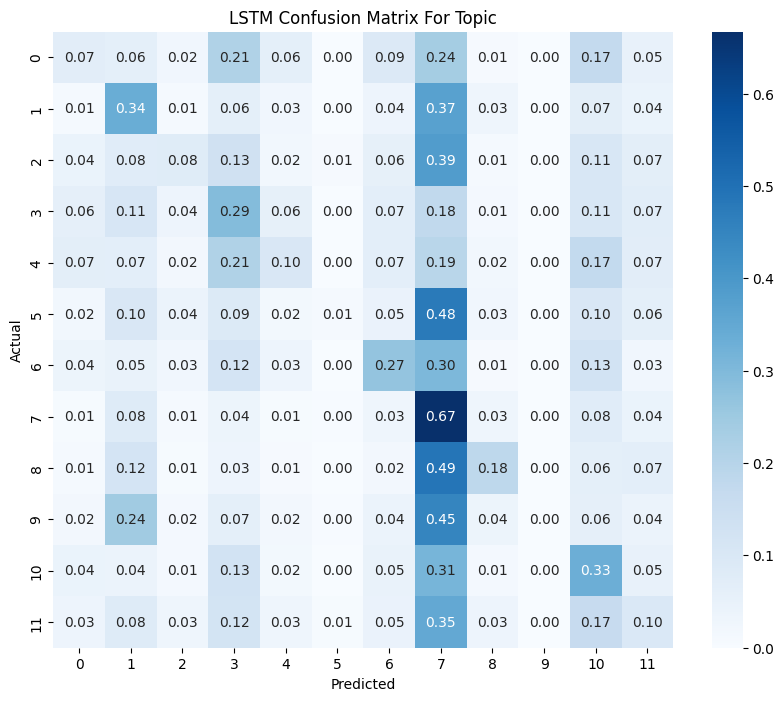

In [ ]:
# Tạo và in ra confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Tính tổng số lượng mẫu thực tế cho mỗi lớp
row_sums = conf_mat.sum(axis=1)

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia cho tổng số lượng mẫu thực tế
norm_conf_mat = conf_mat / row_sums[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels = [f'{val:.2f}' for val in norm_conf_mat.flatten()]
labels = np.asarray(labels).reshape(norm_conf_mat.shape)

# Vẽ ma trận nhầm lẫn đã chuẩn hóa
plt.figure(figsize=(10,8))
sns.heatmap(norm_conf_mat, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix For Topic')
plt.show()

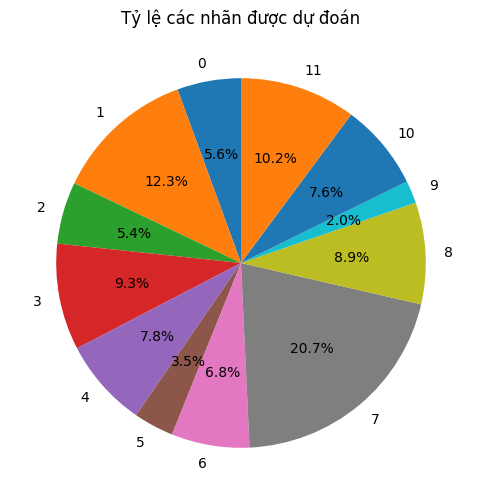

In [ ]:
import matplotlib.pyplot as plt

# Tính số lượng các nhãn
unique_labels, label_counts = np.unique(y_pred, return_counts=True)

# Tạo biểu đồ pie
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)#, colors=['skyblue', 'salmon', 'limegreen'])
plt.title("Tỷ lệ các nhãn được dự đoán")
plt.show()


##test1

In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM_topic.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true = test['Topic'].values

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


338/338 [==============================] - 2s 5ms/step
Accuracy: 0.30266567937800815
Recall: 0.2960400748767231
Precision: 0.3106508819888651
F1 Score: 0.29173337650911707


##Test2


In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM_topic.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true = test['Topic'].values

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


338/338 [==============================] - 3s 3ms/step
Accuracy: 0.07247315808959645
Recall: 0.07943684618455692
Precision: 0.01466854962571922
F1 Score: 0.013974857098938517


##test3


In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM_topic.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true = test['Topic'].values

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


338/338 [==============================] - 3s 4ms/step
Accuracy: 0.17400962606442058
Recall: 0.16276856468434953
Precision: 0.16970323661524844
F1 Score: 0.12076604456834465


##test4



In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM_topic.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true = test['Topic'].values

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


338/338 [==============================] - 1s 4ms/step
Accuracy: 0.3073861532765642
Recall: 0.30263405289619927
Precision: 0.31054651878592976
F1 Score: 0.29894292238885933


##test5

In [ ]:

# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_LSTM_topic.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(val_x, val_y), callbacks=[early_stopping])

Epoch 1/100
2701/2701 [==============================] - 33s 12ms/step - loss: 2.4736 - accuracy: 0.1118 - val_loss: 2.3845 - val_accuracy: 0.1478
Epoch 2/100
2701/2701 [==============================] - 32s 12ms/step - loss: 2.3750 - accuracy: 0.1502 - val_loss: 2.3336 - val_accuracy: 0.1618
Epoch 3/100
2701/2701 [==============================] - 31s 12ms/step - loss: 2.3452 - accuracy: 0.1620 - val_loss: 2.3163 - val_accuracy: 0.1756
Epoch 4/100
2701/2701 [==============================] - 32s 12ms/step - loss: 2.3260 - accuracy: 0.1733 - val_loss: 2.2944 - val_accuracy: 0.1895
Epoch 5/100
2701/2701 [==============================] - 33s 12ms/step - loss: 2.3074 - accuracy: 0.1850 - val_loss: 2.2719 - val_accuracy: 0.2024
Epoch 6/100
2701/2701 [==============================] - 32s 12ms/step - loss: 2.2886 - accuracy: 0.1956 - val_loss: 2.2463 - val_accuracy: 0.2127
Epoch 7/100
2701/2701 [==============================] - 32s 12ms/step - loss: 2.2715 - accuracy: 0.2078 - val_loss: 2

In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])
X_test = X_test.reshape(-1, 1, embedding_dim)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred = model_LSTM_topic.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true = test['Topic'].values

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")


338/338 [==============================] - 1s 3ms/step
Accuracy: 0.30266567937800815
Recall: 0.2960400748767231
Precision: 0.3106508819888651
F1 Score: 0.29173337650911707


##Random Forrest

###12topics

In [ ]:
w2v_model = Word2Vec.load('/content/model_w2v')

In [ ]:
def get_vector(word_list, model):
    # Khởi tạo một vector 0
    vec = np.zeros(model.vector_size).reshape((1, model.vector_size))
    count = 0.
    for word in word_list:
        # Thêm vector của từ vào vec
        vec += model.wv.get_vector(word).reshape((1, model.vector_size))
        count += 1.
    if count != 0:
        vec /= count
    return vec

In [ ]:
train_x = np.concatenate([get_vector(sent, w2v_model) for sent in word_train])
# val_x = np.concatenate([get_vector(sent, w2v_model) for sent in word_valid])
test_x = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])

#xác định các tập để huấn luyện mô hình
train_y = to_categorical(train['Topic'])
# val_y = to_categorical(val['Topic'])

# Kích thước của vector nhúng
# embedding_dim = w2v_model.vector_size
# train_x = train_x.reshape(-1, 1, embedding_dim)
# val_x = val_x.reshape(-1, 1, embedding_dim)


In [ ]:
train_x.shape

(86427, 300)

In [ ]:
train_y.shape

(86427, 12)

In [ ]:
# Tạo mô hình Decision Tree
classifier = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình với dữ liệu huấn luyện Word2Vec
classifier.fit(train_x, train_y)


# Lưu mô hình vào một file
dump(classifier, 'random_forest_topic_classifier.joblib')


['random_forest_topic_classifier.joblib']

In [ ]:
# Dự đoán với dữ liệu kiểm tra
predicted_y = classifier.predict(test_x)
# Chuyển từ dạng one-hot về dạng nhãn
predicted_y = np.argmax(predicted_y, axis=1)

In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test = np.concatenate([get_vector(sent, w2v_model) for sent in word_test])

# Chuyển nhãn thực tế sang dạng số
test_y = test['Topic'].values

# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(test_y, predicted_y)
recall = recall_score(test_y, predicted_y, average='weighted')
precision = precision_score(test_y, predicted_y, average='weighted')
f1 = f1_score(test_y, predicted_y, average='weighted')

# In ra các chỉ số
print(f'Accuracy: {accuracy}')
print(f'Recall:   {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# Tạo và in ra ma trận nhầm lẫn
conf_mat = confusion_matrix(test_y, predicted_y)

Accuracy: 0.10912624953720844
Recall:   0.10912624953720844
Precision: 0.5908215382456975
F1 Score: 0.07043225584840447


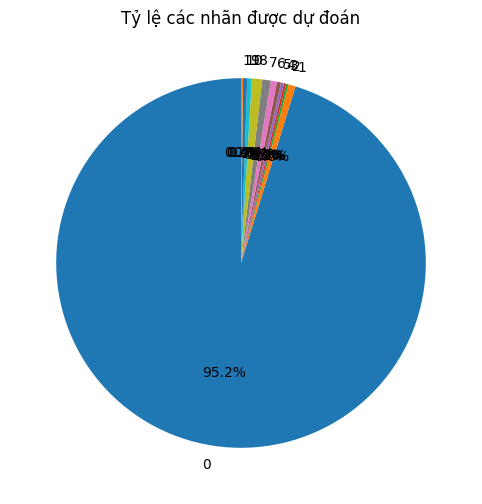

In [ ]:
import matplotlib.pyplot as plt

# Tính số lượng các nhãn
unique_labels, label_counts = np.unique(predicted_y, return_counts=True)

# Tạo biểu đồ pie
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)#, colors=['skyblue', 'salmon', 'limegreen'])
plt.title("Tỷ lệ các nhãn được dự đoán")
plt.show()

###3Topics

In [ ]:
w2v_model = Word2Vec.load('/content/model_w2v')

In [ ]:
def get_vector(word_list, model):
    # Khởi tạo một vector 0
    vec = np.zeros(model.vector_size).reshape((1, model.vector_size))
    count = 0.
    for word in word_list:
        # Thêm vector của từ vào vec
        vec += model.wv.get_vector(word).reshape((1, model.vector_size))
        count += 1.
    if count != 0:
        vec /= count
    return vec

In [ ]:
train_x2 = np.concatenate([get_vector(sent, w2v_model2) for sent in word_train2])
# val_x = np.concatenate([get_vector(sent, w2v_model) for sent in word_valid])
test_x2 = np.concatenate([get_vector(sent, w2v_model2) for sent in word_test2])

#xác định các tập để huấn luyện mô hình
train_y2 = to_categorical(train2['Topic'])
# val_y = to_categorical(val['Topic'])

# Kích thước của vector nhúng
# embedding_dim = w2v_model.vector_size
# train_x = train_x.reshape(-1, 1, embedding_dim)
# val_x = val_x.reshape(-1, 1, embedding_dim)


In [ ]:
train_x.shape

(86427, 300)

In [ ]:
train_y.shape

(86427, 12)

In [ ]:
# Tạo mô hình Decision Tree
classifier = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình với dữ liệu huấn luyện Word2Vec
classifier.fit(train_x2, train_y2)


# Lưu mô hình vào một file
# dump(classifier, 'random_forest_topic_classifier.joblib')


RandomForestClassifier(random_state=42)

In [ ]:
# Dự đoán với dữ liệu kiểm tra
predicted_y2 = classifier.predict(test_x2)
# Chuyển từ dạng one-hot về dạng nhãn
predicted_y2 = np.argmax(predicted_y2, axis=1)

In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test2 = np.concatenate([get_vector(sent, w2v_model2) for sent in word_test2])

# Chuyển nhãn thực tế sang dạng số
test_y2 = test2['Topic'].values

# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(test_y2, predicted_y2)
recall = recall_score(test_y2, predicted_y2, average='weighted')
precision = precision_score(test_y2, predicted_y2, average='weighted')
f1 = f1_score(test_y2, predicted_y2, average='weighted')

# In ra các chỉ số
print(f'Accuracy: {accuracy}')
print(f'Recall:   {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# Tạo và in ra ma trận nhầm lẫn
# conf_mat = confusion_matrix(test_y, predicted_y)

Accuracy: 0.432258064516129
Recall:   0.432258064516129
Precision: 0.790007434953758
F1 Score: 0.55644823240026


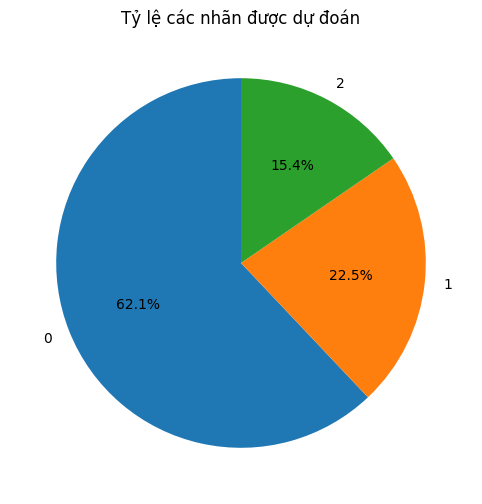

In [ ]:
import matplotlib.pyplot as plt

# Tính số lượng các nhãn
unique_labels, label_counts = np.unique(predicted_y2, return_counts=True)

# Tạo biểu đồ pie
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)#, colors=['skyblue', 'salmon', 'limegreen'])
plt.title("Tỷ lệ các nhãn được dự đoán")
plt.show()

#3topic


##Label Encoding

In [ ]:
enc            = LabelEncoder()
data['Topic']  = pd.Series(enc.fit_transform(data['Topic']))
print(data[['clean_title', 'Topic']])

## Bảng mã
print(data.Topic.unique())
mappings = {index: label for index, label in enumerate(enc.classes_)}
print(mappings)

                                              clean_title  Topic
0       best funny animal funniest dog cat funniest an...      0
1       animal provided youtube roadrunner record anim...      0
2       turf angriest animal animal fight night fin th...      0
3       ocean sea animal beautiful coral reef fish aqu...      0
4       wildlife fascinating world wild animal full se...      0
...                                                   ...    ...
117516  top qatar event april finally got lineup excit...     11
117517  top qatar event june finally got lineup exciti...     11
117518  top qatar event march finally got lineup excit...     11
117519        top planner uganda modern black gold classy     11
117520  fortnite pro carrying lock fortnite pro carryi...     11

[117521 rows x 2 columns]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11}


In [ ]:
data2 = data[data['Topic'].isin([1,2,3])]
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26342 entries, 8185 to 34526
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clean_title  26342 non-null  object
 1   tokens       26342 non-null  object
 2   Topic        26342 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 823.2+ KB


In [ ]:
data2.Topic.value_counts()

1    9116
2    8701
3    8525
Name: Topic, dtype: int64

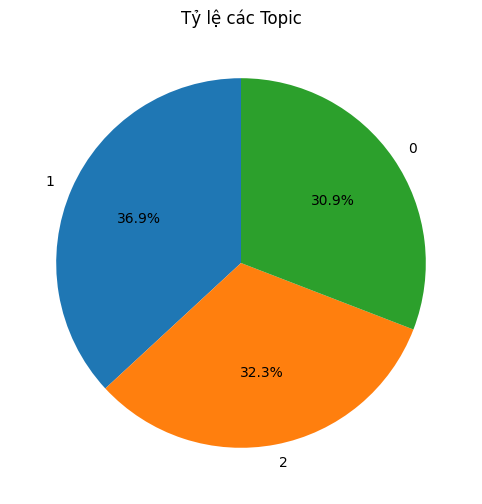

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tạo dataframe mới data2 (đã lọc theo điều kiện)
# data2 = data[data['Topic'].isin([0, 1, 2])]

# Tính số lượng các nhãn trong cột "Topic"
topic_counts = data2['Topic'].value_counts()

# Vẽ biểu đồ pie
plt.figure(figsize=(8, 6))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', startangle=90)#, colors=['skyblue', 'salmon', 'limegreen'])
plt.title("Tỷ lệ các Topic")
plt.show()


##Split Data into Train and Test Data

*   train_data = 80%
*   test_data = 20%


In [ ]:
# Chia tập train (70%) và tập còn lại (30%)
train2, temp_data2 = train_test_split(data2, test_size=0.2, random_state=42)

# Chia tập còn lại thành tập validation (50%) và tập test (50%)
val2, test2 = train_test_split(temp_data2, test_size=0.5, random_state=42)

# In kích thước của các tập dữ liệu
print(f"Kích thước tập train: {len(train2)}")
print(f"Kích thước tập validation: {len(val2)}")
print(f"Kích thước tập test: {len(test2)}")


Kích thước tập train: 21073
Kích thước tập validation: 2634
Kích thước tập test: 2635


In [ ]:
train_x2 = train2['clean_title'].tolist()
val_x2 = val2['clean_title'].tolist()
test_x2 = test2['clean_title'].tolist()

word_train2 = [token for token in train2.tokens]
word_valid2=[token for token in val2.tokens]
word_test2 = [token for token in test2.tokens]

##W2V

In [ ]:
# Cài đặt các chỉ số
min_count=2
window=5
vector_size=100
alpha=1e-3
min_alpha=1e-4
negative=10

In [ ]:
# Tạo mô hình Word2Vec
w2v_model2 = Word2Vec(min_count=min_count, window=window, vector_size=vector_size, alpha=alpha, min_alpha=min_alpha, negative=negative, sg=1)
# Xây dựng từ điển cho tập dữ liệu
w2v_model2.build_vocab(word_train2)
#Huấn luyện mô hình
# w2v_model2.train(word_train2, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1,compute_loss=True)


In [ ]:
# Lưu mô hình sau khi huấn luyện
w2v_model2.save("model_w2v(2)")

##LSTM

In [ ]:
# # Kích thước của từ điển
# vocab_size = len(w2v_model.wv.key_to_index) + 1

# Kích thước của vector nhúng
embedding_dim2 = w2v_model2.vector_size

# Xây dựng mô hình LSTM
model_LSTM_topic2 = Sequential()
model_LSTM_topic2.add(LSTM(units=100, return_sequences=True, input_shape=(1, embedding_dim2)))
model_LSTM_topic2.add(Dropout(0.2))
model_LSTM_topic2.add(LSTM(units=50, return_sequences=True))
model_LSTM_topic2.add(Dropout(0.2))
model_LSTM_topic2.add(LSTM(units=50, return_sequences=True))
model_LSTM_topic2.add(Dropout(0.2))
model_LSTM_topic2.add(LSTM(units=50))
model_LSTM_topic2.add(Dropout(0.2))
model_LSTM_topic2.add(Dense(units=3, activation="softmax"))

# Biên dịch mô hình
model_LSTM_topic2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model_LSTM_topic.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            160400    
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
def get_vector(word_list, model):
    # Khởi tạo một vector 0
    vec = np.zeros(model.vector_size).reshape((1, model.vector_size))
    count = 0.
    for word in word_list:
        # Thêm vector của từ vào vec
        vec += model.wv.get_vector(word).reshape((1, model.vector_size))
        count += 1.
    if count != 0:
        vec /= count
    return vec

In [ ]:
train_x2 = np.concatenate([get_vector(sent, w2v_model2) for sent in word_train2])
val_x2 = np.concatenate([get_vector(sent, w2v_model2) for sent in word_valid2])
test_x2 = np.concatenate([get_vector(sent, w2v_model2) for sent in word_test2])

In [ ]:
#xác định các tập để huấn luyện mô hình
train_y2 = to_categorical(train2['Topic'])
val_y2 = to_categorical(val2['Topic'])

train_x2 = train_x2.reshape(-1, 1, embedding_dim2)
val_x2 = val_x2.reshape(-1, 1, embedding_dim2)


In [ ]:
# Huấn luyện mô hình
# model_LSTM_topic.fit(train_x, train_y, epochs=20, batch_size=32, validation_data=(val_x, val_y))

# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_LSTM_topic2.fit(train_x2, train_y2, epochs=100, batch_size=32, validation_data=(val_x2, val_y2), callbacks=[early_stopping])

Epoch 1/100
711/711 [==============================] - 17s 14ms/step - loss: 1.0550 - accuracy: 0.4174 - val_loss: 0.9606 - val_accuracy: 0.5239
Epoch 2/100
711/711 [==============================] - 8s 12ms/step - loss: 0.9742 - accuracy: 0.5014 - val_loss: 0.9933 - val_accuracy: 0.4993
Epoch 3/100
711/711 [==============================] - 7s 10ms/step - loss: 0.9658 - accuracy: 0.5071 - val_loss: 0.9546 - val_accuracy: 0.5225
Epoch 4/100
711/711 [==============================] - 9s 12ms/step - loss: 0.9563 - accuracy: 0.5154 - val_loss: 0.9408 - val_accuracy: 0.5281
Epoch 5/100
711/711 [==============================] - 8s 11ms/step - loss: 0.9540 - accuracy: 0.5137 - val_loss: 0.9402 - val_accuracy: 0.5296
Epoch 6/100
711/711 [==============================] - 8s 11ms/step - loss: 0.9520 - accuracy: 0.5172 - val_loss: 0.9425 - val_accuracy: 0.5366
Epoch 7/100
711/711 [==============================] - 9s 13ms/step - loss: 0.9498 - accuracy: 0.5160 - val_loss: 0.9303 - val_accuracy

In [ ]:
# model_LSTM_topic.save('model_LSTM_topic.h5')

In [ ]:
# Tạo vector nhúng cho dữ liệu kiểm tra
X_test2 = np.concatenate([get_vector(sent, w2v_model2) for sent in word_test2])
X_test2 = X_test2.reshape(-1, 1, embedding_dim2)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred2 = model_LSTM_topic2.predict(X_test2)
y_pred2 = np.argmax(y_pred2, axis=1)  # Chuyển từ dạng one-hot về dạng nhãn

# Chuyển nhãn thực tế sang dạng số
y_true2 = test2['Topic'].values

# Tính toán các chỉ số
accuracy2 = accuracy_score(y_true2, y_pred2)
recall2 = recall_score(y_true2, y_pred2, average='macro')
precision2 = precision_score(y_true, y_pred, average='macro')
f1_2 = f1_score(y_true2, y_pred2, average='macro')

print(f"Accuracy: {accuracy2}")
print(f"Recall: {recall2}")
print(f"Precision: {precision2}")
print(f"F1 Score: {f1_2}")


89/89 [==============================] - 0s 3ms/step
Accuracy: 0.5233907843826944
Recall: 0.5258576160401606
Precision: 0.24287630191701093
F1 Score: 0.4965560664151439


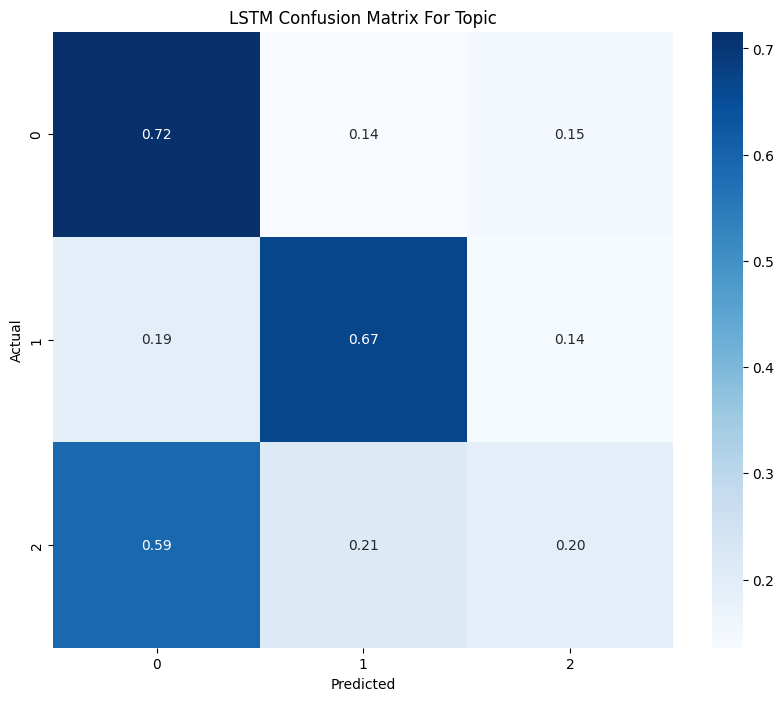

In [ ]:
# Tạo và in ra confusion matrix
conf_mat2 = confusion_matrix(y_true2, y_pred2)

# Tính tổng số lượng mẫu thực tế cho mỗi lớp
row_sums2 = conf_mat2.sum(axis=1)

# Chuẩn hóa ma trận nhầm lẫn bằng cách chia cho tổng số lượng mẫu thực tế
norm_conf_mat2 = conf_mat2 / row_sums2[:, np.newaxis]

# Tạo nhãn cho mỗi ô
labels2 = [f'{val:.2f}' for val in norm_conf_mat2.flatten()]
labels2 = np.asarray(labels2).reshape(norm_conf_mat2.shape)

# Vẽ ma trận nhầm lẫn đã chuẩn hóa
plt.figure(figsize=(10,8))
sns.heatmap(norm_conf_mat2, annot=labels2, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix For Topic')
plt.show()

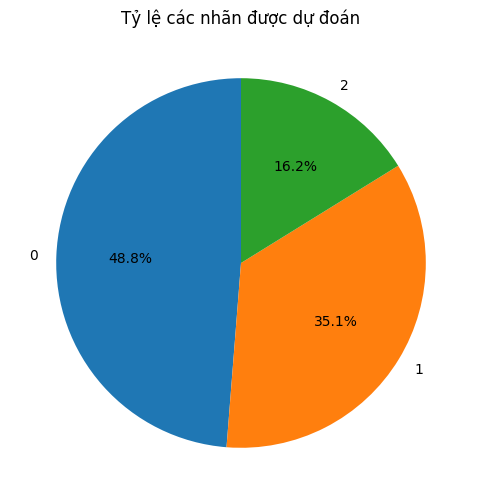

In [ ]:
import matplotlib.pyplot as plt

# Tính số lượng các nhãn
unique_labels, label_counts = np.unique(y_pred2, return_counts=True)

# Tạo biểu đồ pie
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90)#, colors=['skyblue', 'salmon', 'limegreen'])
plt.title("Tỷ lệ các nhãn được dự đoán")
plt.show()
